# **HCA Coding Challenge**
---
Stacey Brandsma <br>
February 18, 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
import sklearn as sk
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xg
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import math
np.random.seed(101)

In [2]:
col_types = {'encounter_id': np.object, 
 'patient_nbr': np.object, 
 'race': np.object,
 'gender': np.object,
 'weight': np.object,
 'discharge_disposition_id' : np.object,
 'admission_source_id' : np.object,
 'admission_type_id' : np.object,
 'time_in_hospital' : np.int64,
 'payer_code' : np.object,
 'medical_specialty' : np.object,
 'num_lab_procedures' : np.int64,
 'num_procedures' : np.int64,
 'num_medications' : np.int64,
 'number_outpatient' : np.int64,
 'number_emergency' : np.int64,
 'diag_1' : np.object,
 'diag_2' : np.object,
 'diag_3' : np.object,
 'number_diagnoses' : np.int64,
 'max_glu_serum' : np.object,
 'A1Cresult' : np.object,
 'metformin' : np.object,
 'repaglinide' : np.object,
 'nateglinide' : np.object,
 'chlorpropamide' : np.object,
 'glimepiride' : np.object,
 'acetohexamide' : np.object,
 'glipizide' : np.object,
 'glyburide' : np.object,
 'tolbutamide' : np.object,
 'pioglitazone' : np.object,
 'rosiglitazone' : np.object,
 'acarbose' : np.object,
 'miglitol' : np.object,
 'troglitazone' : np.object,
 'tolazamide' : np.object,
 'examide' : np.object,
 'citoglipton' : np.object,
 'insulin' : np.object,
 'glyburide-metformin' : np.object,
 'glipizide-metformin' : np.object,
 'glimepiride-pioglitazone' : np.object,
 'metformin-rosiglitazone' : np.object,
 'metformin-pioglitazone' : np.object,
 'change' : np.object,
 'diabetesMed' : np.object,
 'readmitted' : np.object,
 'admit_date' : np.object,
 'birth_date' : np.object
}

df = pd.read_csv('challenge/diabetes_data.csv', na_values = ['?'], dtype=col_types)
df['birth_date'] = pd.to_datetime(df['birth_date'], format='%Y-%m-%d %H:%M:%S')
df['admit_date'] = pd.to_datetime(df['admit_date'], format='%Y-%m-%d %H:%M:%S')

This dataset has missing values denoted by **?**.  I replaced these values with NaN within the read_csv call.  

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date
0,2278392,8222157,Caucasian,Female,NaN,6,25,1,1,NaN,...,No,No,No,No,No,No,No,NO,2002-10-22 06:30:00,1996-07-29 14:28:00
1,149190,55629189,Caucasian,Female,NaN,1,1,7,3,NaN,...,No,No,No,No,No,Ch,Yes,>30,2004-07-24 08:35:00,1985-09-19 11:19:00
2,64410,86047875,AfricanAmerican,Female,NaN,1,1,7,2,NaN,...,No,No,No,No,No,No,Yes,NO,2005-11-30 06:35:00,1983-07-14 07:22:00
3,500364,82442376,Caucasian,Male,NaN,1,1,7,2,NaN,...,No,No,No,No,No,Ch,Yes,NO,2003-05-26 00:32:00,1968-04-05 23:51:00
4,16680,42519267,Caucasian,Male,NaN,1,1,7,1,NaN,...,No,No,No,No,No,Ch,Yes,NO,2004-04-25 04:04:00,1957-11-18 20:30:00


In [4]:
df.tail()

,encounter_id,patient_nbr,race,gender,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date
101761,443847548,100162476,AfricanAmerican,Male,NaN,1,3,7,3,MC,...,No,No,No,No,No,Ch,Yes,>30,2008-08-10 03:37:00,1938-01-11 19:08:00
101762,443847782,74694222,AfricanAmerican,Female,NaN,1,4,5,5,MC,...,No,No,No,No,No,No,Yes,NO,2008-10-26 09:19:00,1921-03-06 19:51:00
101763,443854148,41088789,Caucasian,Male,NaN,1,1,7,1,MC,...,No,No,No,No,No,Ch,Yes,NO,2007-10-13 05:08:00,1924-06-29 10:08:00
101764,443857166,31693671,Caucasian,Female,NaN,2,3,7,10,MC,...,No,No,No,No,No,Ch,Yes,NO,2009-02-19 21:53:00,1919-10-05 12:11:00
101765,443867222,175429310,Caucasian,Male,NaN,1,1,7,6,NaN,...,No,No,No,No,No,No,No,NO,2007-06-14 15:49:00,1936-09-12 19:47:00


## Part 1: Data Analysis and Exploration
##### 1. How many row and columns are in the dataset?

In [5]:
df.shape #rows and columns in the dataset

(101766, 50)

We have 101766 rows and 50 columns in our data.  
##### 2. How many men are represented in the data versus women?

In [6]:
df.gender.value_counts() #count of gender categories

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [7]:
df.gender.value_counts()/len(df)*100 #percentage of gender categories

Female             53.758623
Male               46.238429
Unknown/Invalid     0.002948
Name: gender, dtype: float64

In [8]:
df.loc[df['gender'] == 'Unknown/Invalid'] #looking at what values are unknown/invalid

,encounter_id,patient_nbr,race,gender,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date
30506,98634858,100695042,Other,Unknown/Invalid,NaN,3,1,1,1,NaN,...,No,No,No,No,No,Ch,Yes,NO,2006-07-25 20:03:00,1930-07-30 08:44:00
75551,226864668,60524946,NaN,Unknown/Invalid,NaN,1,1,7,1,CP,...,No,No,No,No,No,No,No,NO,2007-08-12 13:25:00,1939-04-10 12:11:00
82573,257364294,78119847,NaN,Unknown/Invalid,NaN,1,22,7,8,CP,...,No,No,No,No,No,Ch,Yes,NO,2008-02-15 00:53:00,1936-12-05 13:40:00


In [9]:
ratio = (df['gender']=='Male').sum()/(df['gender']=='Female').sum() #ratio of male to female
print(ratio)

0.8601118666374205


We have **54708** females and **47055** males in the dataset which gives us **53.75%** and **46.24%** respectively.  We have 3 (0.0029%) patients/rows where the gender is listed as Unknown/Invalid.  There are **0.86** men to women in the dataset.  

##### 3. What percent of the patients are African American?

In [10]:
df.race.value_counts() #count of race categories

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [11]:
df.race.value_counts()/len(df)*100 #percentage of race categories

Caucasian          74.778413
AfricanAmerican    18.876639
Hispanic            2.001651
Other               1.479866
Asian               0.629876
Name: race, dtype: float64

**18.9%** percent of patients are African American.

##### 4. What is the approximate average age of female patients in the dataset?

First calculate the age of the patients in an additional column "age".

In [12]:
now = pd.Timestamp('now')
df['age'] = (now-df['birth_date']).astype('<m8[Y]') #calculating the age of each patient
df['age'] = df.age.astype('int64')
df.head()

,encounter_id,patient_nbr,race,gender,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date,age
0,2278392,8222157,Caucasian,Female,NaN,6,25,1,1,NaN,...,No,No,No,No,No,No,NO,2002-10-22 06:30:00,1996-07-29 14:28:00,23
1,149190,55629189,Caucasian,Female,NaN,1,1,7,3,NaN,...,No,No,No,No,Ch,Yes,>30,2004-07-24 08:35:00,1985-09-19 11:19:00,34
2,64410,86047875,AfricanAmerican,Female,NaN,1,1,7,2,NaN,...,No,No,No,No,No,Yes,NO,2005-11-30 06:35:00,1983-07-14 07:22:00,36
3,500364,82442376,Caucasian,Male,NaN,1,1,7,2,NaN,...,No,No,No,No,Ch,Yes,NO,2003-05-26 00:32:00,1968-04-05 23:51:00,51
4,16680,42519267,Caucasian,Male,NaN,1,1,7,1,NaN,...,No,No,No,No,Ch,Yes,NO,2004-04-25 04:04:00,1957-11-18 20:30:00,62


In [13]:
df.loc[df['gender'] == 'Female']['age'].mean() #calculating mean of female patients

82.08486875776852

In [14]:
df.groupby('gender')['age'].mean() #calculating the means of each group in gender

gender
Female             82.084869
Male               80.556519
Unknown/Invalid    84.000000
Name: age, dtype: float64

The approximate average age for female patients in the dataset is **82** years old.  This is a few years older than the men, whose approximate average age is 80 years old.  

##### 5. Which features have more than 50% missing data?

In [15]:
df.isnull().sum().sort_values(ascending=False)/len(df)*100 #calculating percentage of missing values for each variable

weight                      96.858479
medical_specialty           49.082208
payer_code                  39.557416
race                         2.233555
diag_3                       1.398306
diag_2                       0.351787
diag_1                       0.020636
age                          0.000000
number_outpatient            0.000000
metformin                    0.000000
A1Cresult                    0.000000
max_glu_serum                0.000000
number_diagnoses             0.000000
number_emergency             0.000000
num_lab_procedures           0.000000
num_medications              0.000000
num_procedures               0.000000
nateglinide                  0.000000
time_in_hospital             0.000000
admission_source_id          0.000000
discharge_disposition_id     0.000000
admission_type_id            0.000000
gender                       0.000000
patient_nbr                  0.000000
repaglinide                  0.000000
chlorpropamide               0.000000
birth_date  

Only weight has more than 50% missing values.  Payer_code and medical_specialty have the next highest rates of missing values, although they are less than 50%.  

##### 6. Write a function to remove features from the dataset that have a high proportion of missing values.

In [16]:
def remove_features(data, percentage=30.00):
    null_percentage = data.isnull().sum()/len(df)*100 #list of percentage of missing values
    for i,feature in enumerate(data.columns):
       if null_percentage[i]>=percentage: #if greater than the desired percentage
           data.drop(feature, axis=1, inplace=True) #drop from data
    
    return data

df_sub = df.copy()
df_sub = remove_features(df_sub)
df_sub.shape

(101766, 48)

In [17]:
df_sub.head() #expected columns were dropped

,encounter_id,patient_nbr,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date,age
0,2278392,8222157,Caucasian,Female,6,25,1,1,41,0,...,No,No,No,No,No,No,NO,2002-10-22 06:30:00,1996-07-29 14:28:00,23
1,149190,55629189,Caucasian,Female,1,1,7,3,59,0,...,No,No,No,No,Ch,Yes,>30,2004-07-24 08:35:00,1985-09-19 11:19:00,34
2,64410,86047875,AfricanAmerican,Female,1,1,7,2,11,5,...,No,No,No,No,No,Yes,NO,2005-11-30 06:35:00,1983-07-14 07:22:00,36
3,500364,82442376,Caucasian,Male,1,1,7,2,44,1,...,No,No,No,No,Ch,Yes,NO,2003-05-26 00:32:00,1968-04-05 23:51:00,51
4,16680,42519267,Caucasian,Male,1,1,7,1,51,0,...,No,No,No,No,Ch,Yes,NO,2004-04-25 04:04:00,1957-11-18 20:30:00,62


3 columns were removed (weight, payer_id, medical_specialty) from the dataset whose percentage of missing values was greater than or equal to 30%.  Note, the age column earlier, which is why we have 48 columns.

##### 7. The business owner you are working with is concerned about patients who are readmitted within 30 days.  She wants to know which medical specialty has the biggest problem with readmissions.  What do you tell her?

Lets dive into the _medical_specialty_ variable.  We already know that it has approximately 49% missing data.  Lets explore this more. 

Lets take a look at all of the data in a crosstab.  By creating a two-way table we can see how the categorical variables are related to each other. <br>
The first three columns give us counts of each medical_specialty for their corresponding readmission status.  I've added two additional columns to the table, the first additional column being the percentage of patients who readmit <30 days for each specialty.  The second additional column is the percentage of the readmitted within 30 days patients with this specialty out of the total patients who were readmitted within 30 days.  

In [18]:
med_sp_twt = pd.crosstab(index=df["medical_specialty"].fillna('missing'), 
                          columns=df["readmitted"])
med_sp_twt['perc<30_med_spec'] = med_sp_twt['<30']/(med_sp_twt['<30']+med_sp_twt['>30']+med_sp_twt['NO'])*100 # percentage of <30 for medical specialty
med_sp_twt['perc<30_total'] = (med_sp_twt['<30']/med_sp_twt['<30'].sum())*100 #percentage of total <30 status
med_sp_twt.sort_values(by=['perc<30_total'], ascending=False).head(10)


readmitted,<30,>30,NO,perc<30_med_spec,perc<30_total
medical_specialty,,,,,
missing,5781,18216,25952,11.573805,50.902527
InternalMedicine,1646,4723,8266,11.247011,14.493264
Family/GeneralPractice,883,2663,3894,11.868280,7.774941
Emergency/Trauma,846,3006,3713,11.183080,7.449150
Cardiology,425,1853,3074,7.940957,3.742185
Surgery-General,342,1046,1711,11.035818,3.011359
Nephrology,248,666,699,15.375077,2.183675
Orthopedics,151,327,922,10.785714,1.329576
Psychiatry,104,262,488,12.177986,0.915735



Lets look at the first column _percent<30_med_spec:_ this gives us the rate of <30days readmission status for a given specialty.  This rate can be misleading.  For example, when we sort the table by percent<30_med_spec and show the top ten specialties.  

In [19]:
med_sp_twt.sort_values(by=['perc<30_med_spec'], ascending=False).head(10)

readmitted,<30,>30,NO,perc<30_med_spec,perc<30_total
medical_specialty,,,,,
Resident,1,1,0,50.000000,0.008805
AllergyandImmunology,3,3,1,42.857143,0.026415
Hematology,26,24,32,31.707317,0.228934
Pediatrics-Hematology-Oncology,1,0,3,25.000000,0.008805
InfectiousDiseases,8,12,17,21.621622,0.070441
Hematology/Oncology,40,64,103,19.323671,0.352206
Oncology,66,100,182,18.965517,0.581139
PhysicianNotFound,2,4,5,18.181818,0.017610
Rheumatology,3,5,9,17.647059,0.026415


We can see above that the specialties with the highest rate of readmission have a very low number of readmitted patients overall. Thus stasticially significant conclusions can not be made due to the low sample size of total patients. In addition, if the business were to focus efforts to reduce readmission with Residents or Allergy&Immunology, the impact to the overall organization would be minimal as these specialties have a combined total of 9 patients. Hematology/Oncology and Oncology have more patients; however readmission improvement results are not likely due to the nature of the specialty. <br> <br>
Lets take a look at the overall percentage of readmitted patients by specialties again.  

In [20]:
med_sp_twt.sort_values(by=['perc<30_total'], ascending=False).head(10)

readmitted,<30,>30,NO,perc<30_med_spec,perc<30_total
medical_specialty,,,,,
missing,5781,18216,25952,11.573805,50.902527
InternalMedicine,1646,4723,8266,11.247011,14.493264
Family/GeneralPractice,883,2663,3894,11.868280,7.774941
Emergency/Trauma,846,3006,3713,11.183080,7.449150
Cardiology,425,1853,3074,7.940957,3.742185
Surgery-General,342,1046,1711,11.035818,3.011359
Nephrology,248,666,699,15.375077,2.183675
Orthopedics,151,327,922,10.785714,1.329576
Psychiatry,104,262,488,12.177986,0.915735


Here we have _InternalMedicine, Family/GeneralPractice, & Emergency/Trauma_ having the highest rate of patients who were readmitted within 30 days (excluding missing values). However, all of the top specialties are substantially less than the percentage missing values.  


Since the medical specialty is missing for approximately 50% of the patients who are readmitted within 30 days, I would show my business partner this analysis and specify that we need to gather more specialty data in order to confidently determine the relationship between specialty and readmission status.  I would also elaborate that a higher rate of readmission within 30 days does not mean that a certain specialty causes a patient to readmit. Certain specialties may have higher associations with readmission for a wide variety of factors. 

## Part 2: Build a Model
##### Build a predictive model to identify patients at risk of readmitting within 30 days.  Evaluate your model.

First, remove the missing values from the columns that still have them.  

In [21]:
df_model = df_sub.copy()
df_model = df_model.dropna(axis=0) #dropping rows with null values
# we are dropping 3713 rows out of a total of 101766, approximately 3.64%
y = df_model['readmitted']
df_model.drop(['readmitted','encounter_id', 'patient_nbr', 'birth_date', 'admit_date'], axis=1, inplace=True) #dropping unnecessary columns


In [22]:
df_model.head()

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,age
1,Caucasian,Female,1,1,7,3,59,0,18,0,...,No,Up,No,No,No,No,No,Ch,Yes,34
2,AfricanAmerican,Female,1,1,7,2,11,5,13,2,...,No,No,No,No,No,No,No,No,Yes,36
3,Caucasian,Male,1,1,7,2,44,1,16,0,...,No,Up,No,No,No,No,No,Ch,Yes,51
4,Caucasian,Male,1,1,7,1,51,0,8,0,...,No,Steady,No,No,No,No,No,Ch,Yes,62
5,Caucasian,Male,2,1,2,3,31,6,16,0,...,No,Steady,No,No,No,No,No,No,Yes,69


Next we need to look at our categorical variables.  First, we want to test if there is a relationship between the categorical variables and our response variable of readmission.  Then, for the categorical variables that are going to be important in our model, I will create dummy variables so that we can utilize them.
1. race
2. gender
3. admission_type_id
4. discharge_disposition_id
5. admission_source_id
6. max_glu_serum - ordinal data
7. A1result - ordinal data
8. metformin
9. repaglinide
10. nateglinide
11. chloropromide
12. glimepiride
13. acetohexamide
14. glipizide
15. glyburide
16. tolbutamide
17. pioglitazone
18. rosiglitazone
19. acarbose
20. miglitol
21. troglitazone
22. tolazamde
23. examide
24. citoglipton
25. insulin
26. glyburide-metformin	
27. glipizide-metformin	
28. glimepiride-pioglitazone	
29. metformin-rosiglitazone	
30. metformin-pioglitazone	
31. change	
32. diabetesMed


For the diagnoses (_diag_1, diag_2, diag_3_) variables, I will group them together by their classification of diseases according to the International Statisical Classification of Diseases and Releated Health Problems.  <br>
<url>https://en.wikipedia.org/wiki/List_of_ICD-9_codes</url>

1. 001-139: infectious and parasitic diseases (infectPara)
2. 140–239: neoplasms (neoplasm)
3. 240–279: endocrine, nutritional and metabolic diseases, and immunity disorders (enmi)
4. 280–289: diseases of the blood and blood-forming organs (blood)
5. 290–319: mental disorders (mental)
6. 320-389: diseases of the nervous system and sense organs (nervous)
7. 390-459: diseases of the circulatory system (circ)
8. 460-519: diseases of the respiratory system (resp)
9. 520-579: diseases of the digestive system (digest)
10. 580-629: diseases of the genitourinary system (genit)
11. 630–679: complications of pregnancy, childbirth, and the puerperium (pregChild)
12. 680–709: diseases of the skin and subcutaneous tissue (skin)
13. 710–739: diseases of the musculoskeletal system and connective tissue (muscle)
14. 740–759: congenital anomalies (congenital)
15. 760–779: certain conditions originating in the perinatal period (perinatal)
16. 780–799: symptoms, signs, and ill-defined conditions (symptom)
17. 800–999: injury and poisoning (injPois)
18. E and V codes: external causes of injury and supplemental classification (extSupp)

In [23]:
# ordinal encoding of A1Cresult and max_glu_serum
encoder = sk.preprocessing.OrdinalEncoder(categories=[['None','Norm','>7','>8']])
df_model.A1Cresult = encoder.fit_transform(df_model.A1Cresult.values.reshape(-1,1)) 
encoder = sk.preprocessing.OrdinalEncoder(categories=[['None','Norm','>200','>300']])
df_model.max_glu_serum = encoder.fit_transform(df_model.max_glu_serum.values.reshape(-1,1))

In [24]:
# grouping diagnosis variables according to https://en.wikipedia.org/wiki/List_of_ICD-9_codes

df_model['diag_1_id'] = df_model['diag_1']
df_model['diag_2_id'] = df_model['diag_2']
df_model['diag_3_id'] = df_model['diag_3']

def rep_diag(df, col_name):
  for i, row in df.iterrows():
    if 'E' in row[col_name] or 'V' in row[col_name]:
      df.at[i,col_name] = 'extSupp'
    elif float(row[col_name])<=139:
      df.at[i,col_name] = 'infectPara'
    elif float(row[col_name])<=279:
      df.at[i,col_name] = 'neoplasm'
    elif float(row[col_name])<=289:
      df.at[i,col_name] = 'enmi'
    elif float(row[col_name])<=319:
      df.at[i,col_name] = 'mental'
    elif float(row[col_name])<=389:
      df.at[i,col_name] = 'nervous'
    elif float(row[col_name])<=459:
      df.at[i,col_name] = 'circ'
    elif float(row[col_name])<=519:
      df.at[i,col_name] = 'resp'
    elif float(row[col_name])<=579:
      df.at[i,col_name] = 'digest'
    elif float(row[col_name])<=629:
      df.at[i,col_name] = 'genit'
    elif float(row[col_name])<=679:
      df.at[i,col_name] = 'pregChild'
    elif float(row[col_name])<=709:
      df.at[i,col_name] = 'skin'
    elif float(row[col_name])<=739:
      df.at[i,col_name] = 'muscle'
    elif float(row[col_name])<=759:
      df.at[i,col_name] = 'congenital'
    elif float(row[col_name])<=779:
      df.at[i,col_name] = 'perinatal'
    elif float(row[col_name])<=799:
      df.at[i,col_name] = 'symptom'
    elif float(row[col_name])<=999:
      df.at[i,col_name] = 'injPois'
  return df

rep_diag(df_model, 'diag_1')
rep_diag(df_model, 'diag_2')
rep_diag(df_model, 'diag_3')

df_model.head()

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,age,diag_1_id,diag_2_id,diag_3_id
1,Caucasian,Female,1,1,7,3,59,0,18,0,...,No,No,No,No,Ch,Yes,34,276,250.01,255
2,AfricanAmerican,Female,1,1,7,2,11,5,13,2,...,No,No,No,No,No,Yes,36,648,250,V27
3,Caucasian,Male,1,1,7,2,44,1,16,0,...,No,No,No,No,Ch,Yes,51,8,250.43,403
4,Caucasian,Male,1,1,7,1,51,0,8,0,...,No,No,No,No,Ch,Yes,62,197,157,250
5,Caucasian,Male,2,1,2,3,31,6,16,0,...,No,No,No,No,No,Yes,69,414,411,250


**Feature Selection:**  <br> I will be using a chi squared test to determine which of the categorical variables are important.   

In [25]:
#chi sq test for feature selection (categorical variables)
cat_vars = df_model.copy()
cat_vars = cat_vars.drop(['time_in_hospital', 'num_lab_procedures', 
                          'num_procedures', 'num_medications', 
                          'number_outpatient', 'number_emergency', 
                          'number_diagnoses', 'age'],
                         axis=1, inplace=False) #subsetting to include only categorical variables

label_encoder = LabelEncoder()
for i,feature in enumerate(cat_vars.columns):
    cat_vars[feature] = label_encoder.fit_transform(cat_vars[feature]) # label encoding each categorical variable

lab_encoder = sk.preprocessing.LabelEncoder().fit(["<30", ">30", "NO"])
y_lab = label_encoder.fit_transform(y)

chi_scores = chi2(cat_vars,y_lab)
p_values = pd.Series(chi_scores[1],index = cat_vars.columns).sort_values(ascending=False) #sorting values by p value
p_values.head(50)

miglitol                     9.990575e-01
chlorpropamide               9.981376e-01
glyburide-metformin          9.930507e-01
nateglinide                  9.924186e-01
acarbose                     9.521332e-01
glyburide                    8.282182e-01
race                         7.891118e-01
glimepiride                  7.618509e-01
repaglinide                  6.974255e-01
insulin                      6.500353e-01
metformin-pioglitazone       6.461468e-01
troglitazone                 4.971622e-01
tolazamide                   4.706592e-01
rosiglitazone                4.592483e-01
pioglitazone                 4.167468e-01
acetohexamide                4.005378e-01
glimepiride-pioglitazone     4.005378e-01
glipizide-metformin          3.770185e-01
tolbutamide                  3.338956e-01
glipizide                    2.360717e-01
metformin                    5.014193e-04
gender                       1.560339e-04
admission_type_id            3.052246e-06
A1Cresult                    9.070

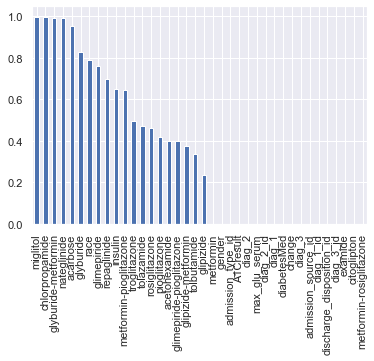

In [26]:
p_values.plot.bar()


This test allows us to determine if categorical variables are independent.  If they are not independent, then we will include them in our model because they will allow us to predict readmission status.  A p-value greater than 0.05 does not allow us to reject the null hypothesis of independence, and therefore we do not want to consider these variables in our model.  

In [27]:
#create variety of dataframes for modelling

df_model_sub = df_model.drop(['glyburide-metformin', 
               'chlorpropamide', 
               'nateglinide', 
               'repaglinide', 
               'glimepiride',
               'rosiglitazone',
               'glipizide',
               'miglitol',
               'tolazamide',
               'pioglitazone',
               'glyburide',
               'troglitazone',
               'acarbose',
               'acetohexamide',
               'tolbutamide',
               'insulin',
               'race',
               'metformin-pioglitazone',
               'glimepiride-pioglitazone',
               'glipizide-metformin',
               'diag_1_id',
               'diag_2_id',
               'diag_3_id'], axis=1, inplace=False)

df_model_subids = df_model.drop(['glyburide-metformin', 
               'chlorpropamide', 
               'nateglinide', 
               'repaglinide', 
               'glimepiride',
               'rosiglitazone',
               'glipizide',
               'miglitol',
               'tolazamide',
               'pioglitazone',
               'glyburide',
               'troglitazone',
               'acarbose',
               'acetohexamide',
               'tolbutamide',
               'insulin',
               'race',
               'metformin-pioglitazone',
               'glimepiride-pioglitazone',
               'glipizide-metformin',
               'diag_1',
               'diag_2',
               'diag_3'], axis=1, inplace=False)

df_model = df_model.drop([
               'diag_1_id',
               'diag_2_id',
               'diag_3_id'], axis=1, inplace=False)


In [28]:
#creating dummy variables to use in modeling
data = pd.get_dummies(df_model)
data.shape

(98053, 191)

In [29]:
data_sub = pd.get_dummies(df_model_sub)
data_sub.shape

(98053, 123)

Before we get into modeling, lets take a look at the response variable

<BarContainer object of 3 artists>

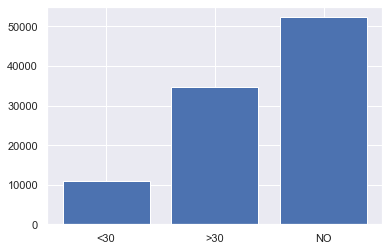

In [30]:
# plot the counts of each readmission status
vals, cts = np.unique(y, return_counts=True)
plt.bar(vals, cts)

In [31]:
# finding percentage of each readmission status
for (i,j) in zip(vals,cts):
  print(i,':',j/len(y)*100)

<30 : 11.285733225908437
>30 : 35.33701161616677
NO : 53.37725515792479


Overall, our dataset containes approximately 11% of the group we are interested in predicting (<30 days).  After splitting the test and train data I will do some oversampling techniques to artificially equal out the representation of the groups.  This technique forces the model to take notice of the minority groups and learn to predict them as well.  

#### Modeling Plan
1. Build Logistic Regression Model with all variables
2. Build Logistic Regression Model with a subset of variables
3. Build Logistic Regression Model using Randomized Search CV
4. Build Random Forest Model using Randomized Search CV

For each of the models above, I want to look at the difference between binary-encoding the response variable (1 = <30 days, 0 = else) and label-encoding (0 = <30 days, 1 = >30 days, 2 = NO).  Binary-encoding could make sense because the only response variable we are interested in is <30 days.  However, this may reduce the accuracy of the model because there may be characteristics that slightly differentiate <30 days and >30 days, but are different than no readmission.  This would be the rationale behind label-encoding the response.   

I chose to start with a logistic regression model because we are looking for the probability of short-term readmission.  A logistic regression is great for
these types of problems because it gives us a value between 0 and 1. In addition it is simple
to explain for those clients who aren’t versed in complex modeling tactics.

In [32]:
#label and binary encoding
lab_encoder = sk.preprocessing.LabelEncoder().fit(["<30", ">30", "NO"])
y_lab = label_encoder.fit_transform(y)

y_oh = pd.get_dummies(y)
y_oh = y_oh['<30']

In [33]:
#standardizing the data
sc = sk.preprocessing.StandardScaler().fit(data)
data_sc = sc.transform(data)

In [34]:
#splitting into train & test
bin_X_train, bin_X_test, bin_y_train, bin_y_test = sk.model_selection.train_test_split(data_sc, y_oh, test_size=0.3, random_state=0)

In [35]:
bin_logm = sk.linear_model.LogisticRegressionCV(cv = 6, random_state=0)
bin_logm.fit(bin_X_train, bin_y_train)
bin_log_all_predictions = bin_logm.predict(bin_X_test)

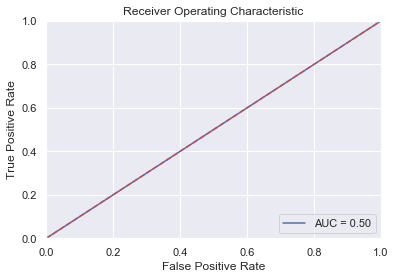

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     26107
           1       0.00      0.00      0.00      3309

    accuracy                           0.89     29416
   macro avg       0.44      0.50      0.47     29416
weighted avg       0.79      0.89      0.83     29416



In [36]:
fpr, tpr, threshold = sk.metrics.roc_curve(bin_y_test, bin_log_all_predictions)
roc_auc = sk.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(sk.metrics.classification_report(bin_y_test, bin_log_all_predictions))

The recall for our variable of interest (1) is extremely low.  This proves that the model is biased towards the majority class (0).  The ROC curve on this model is just a straight line, which means it is no better than randomly guessing.  Even though the overall accuracy is quite high, the model is essentially just predicting that every patient will not readmit.  Because 89% of the data has this label, this model is correct 89% of the time.  For our purposes however, this is suboptimal as we are trying to predict whether someone will readmit within 30 days, not just defaulting each patient to no readmission.  This is why we want to resample.  We will force the model to take notice of the <30 days category and force it to differentiate between the groups.  

In [37]:
#binary encoder: all variables
#resampling
smt = SMOTE()
bin_X_train_smt, bin_y_train_smt = smt.fit_sample(bin_X_train, bin_y_train)

In [38]:
#modeling: logistic regression with binary encoding all variables
bin_log_all_logm = sk.linear_model.LogisticRegressionCV(cv = 6, random_state=0, class_weight='balanced')
bin_log_all_model = bin_log_all_logm.fit(bin_X_train_smt, bin_y_train_smt)
bin_log_all_predictions = bin_log_all_logm.predict(bin_X_test)

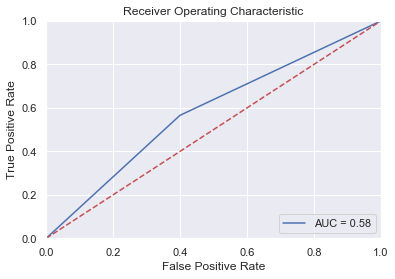

              precision    recall  f1-score   support

           0       0.92      0.60      0.73     26107
           1       0.15      0.57      0.24      3309

    accuracy                           0.60     29416
   macro avg       0.53      0.58      0.48     29416
weighted avg       0.83      0.60      0.67     29416



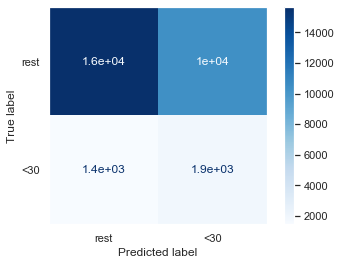

In [39]:
#determining roc metrics and plotting ROC curve, classification report, and confusion matrix
fpr, tpr, threshold = sk.metrics.roc_curve(bin_y_test, bin_log_all_predictions)
roc_auc = sk.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(sk.metrics.classification_report(bin_y_test, bin_log_all_predictions))

sk.metrics.plot_confusion_matrix(bin_log_all_model, bin_X_test, bin_y_test, display_labels=["rest","<30"], cmap=plt.cm.Blues)
plt.grid(None)

Lets walk through these values.  We can see that resampling makes a substantial improvement on the recall of the model.
**Precision/Positive Predictive Value:** how many selected items are relevant?
```
precision = true positive / (true positive + false positive)
```
**Recall/Sensitivity**: how many relevant items are selected?

```
recall = true positive / (true positive + false negative)
```
So for our variable of interest of <30 days readmission (0), we have a precision of 0.15 and a recall of 0.56.  
<br>
Of the total patients that this model predicted would readmit within 30 days, only 15% of them actually did.  This means that we predicted 15% true positives.  In addition, of all the patients that truly readmitted within 30 days, this model identified 56% of them.  We can see the actual counts of patients in the confusion matrix above.  <br><br>
True Positives: 1.9e03 patients<br>
False Positives: 1.0e04 patients<br>
True Negatives: 1.6e04 patients<br>
False Negatives: 1.4e03 patients<br>
<br>
The ROC curve has improved with the resampling, with an AUC of 0.58.  
<br>
Ideally, I'd like the precision and recall to both be higher.  I am more concerned about the recall because it would be better to have false positives than false negatives.  Intuitively, I would rather be cautious and predict that someone will readmit even if they actually don't.  This is preferred to missing out on a patient that will actually readmit.  This question would be further discussed with the business partners.  
<br>
Lets try some new techniques to improve these metrics.  


Lets see what happens when we use a label encoder instead of a binary encoder.  

In [40]:
#label encoder: all variables
#splitting data
lab_X_train, lab_X_test, lab_y_train, lab_y_test = sk.model_selection.train_test_split(data_sc, y_lab, test_size=0.3, random_state=0)
#smote
smt = SMOTE()
lab_X_train_smt, lab_y_train_smt = smt.fit_sample(lab_X_train, lab_y_train)

In [41]:
#modelling: logistic regression with label encoding all variables
lab_log_all_logm = sk.linear_model.LogisticRegressionCV(cv = 6, random_state=0, class_weight='balanced')
lab_log_all_model = lab_log_all_logm.fit(lab_X_train_smt, lab_y_train_smt)
lab_log_all_predictions = lab_log_all_logm.predict(lab_X_test)

print(sk.metrics.classification_report(lab_y_test, lab_log_all_predictions))

              precision    recall  f1-score   support

           0       0.16      0.41      0.23      3309
           1       0.45      0.38      0.42     10531
           2       0.65      0.51      0.57     15576

    accuracy                           0.45     29416
   macro avg       0.42      0.43      0.41     29416
weighted avg       0.53      0.45      0.48     29416



We can see that the label encoding reduced our recall for <30 days (0 in the summary above) to 0.42 and our precision is 0.16.  This means that a binary encoding might be a better method for this analysis.  One reason for this is that if a person readmits after 30 days, they are likely readmitting for something that is not related to the inital visit and therefore they would have more similarity to those patients who do not readmit at all. <br>

Next, lets see if subsetting the data gives us as good of a result as using the entire dataset.  Normally we do not want to use all of the variables, just those that are important in prediction.  

In [42]:
#standardize the subset data
sc_sub = sk.preprocessing.StandardScaler().fit(data_sub)
data_sub_sc = sc_sub.transform(data_sub)
#binary encoder: subset of variables
bin_sub_X_train, bin_sub_X_test, bin_sub_y_train, bin_sub_y_test = sk.model_selection.train_test_split(data_sub_sc, y_oh, test_size=0.3, random_state=0)
#resampling
smt = SMOTE()
bin_sub_X_train_smt, bin_sub_y_train_smt = smt.fit_sample(bin_sub_X_train, bin_sub_y_train)

In [43]:
#modelling: logistic regression with binary encoding with a subset of variables
bin_log_sub_logm = sk.linear_model.LogisticRegressionCV(cv = 6, random_state=0)
bin_log_sub_model = bin_log_sub_logm.fit(bin_sub_X_train_smt, bin_sub_y_train_smt)
bin_log_sub_predictions = bin_log_sub_logm.predict(bin_sub_X_test)

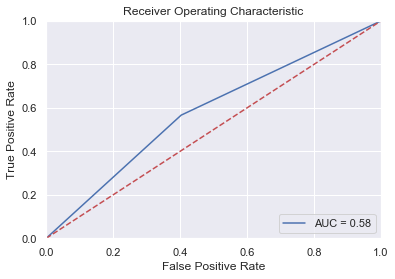

              precision    recall  f1-score   support

           0       0.92      0.60      0.72     26107
           1       0.15      0.57      0.24      3309

    accuracy                           0.59     29416
   macro avg       0.53      0.58      0.48     29416
weighted avg       0.83      0.59      0.67     29416



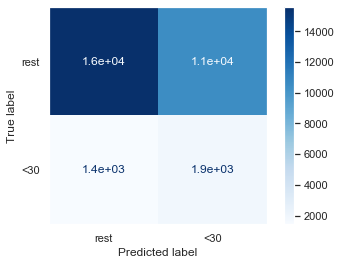

In [44]:
#determining roc metrics and plotting ROC curve, classification report, and confusion matrix
fpr, tpr, threshold = sk.metrics.roc_curve(bin_sub_y_test, bin_log_sub_predictions)
roc_auc = sk.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(sk.metrics.classification_report(bin_sub_y_test, bin_log_sub_predictions))

sk.metrics.plot_confusion_matrix(bin_log_sub_model, bin_sub_X_test, bin_sub_y_test, display_labels=["rest","<30"], cmap=plt.cm.Blues)
plt.grid(None)

We have similar results with the subset as compared to the full data, slightly improved recall. Lets see what we get with label encoding.  

In [45]:
#label encoder: subset of variables
lab_sub_X_train, lab_sub_X_test, lab_sub_y_train, lab_sub_y_test = sk.model_selection.train_test_split(data_sub_sc, y_lab, test_size=0.3, random_state=0)
#resampling
smt = SMOTE()
lab_sub_X_train_smt, lab_sub_y_train_smt = smt.fit_sample(lab_sub_X_train, lab_sub_y_train)

In [46]:
#modelling: logistic regression with label encoding with a subset of variables
lab_sub_log_all_logm = sk.linear_model.LogisticRegressionCV(cv = 4, random_state=0, class_weight='balanced')
lab_sub_log_all_model = lab_sub_log_all_logm.fit(lab_sub_X_train_smt, lab_sub_y_train_smt)
lab_sub_log_all_predictions = lab_sub_log_all_logm.predict(lab_sub_X_test)

print(sk.metrics.classification_report(lab_sub_y_test, lab_sub_log_all_predictions))

              precision    recall  f1-score   support

           0       0.16      0.41      0.23      3309
           1       0.45      0.39      0.42     10531
           2       0.65      0.51      0.57     15576

    accuracy                           0.45     29416
   macro avg       0.42      0.44      0.41     29416
weighted avg       0.53      0.45      0.48     29416



We can see that we get equivalent results when we use a subset of the data as compared to the entire dataset, for both binary and label encoding.  From now on, I will just use the subset data rather than the entire dataset and I will stick to binary encoding rather than label encoding.  <br> <br>

Our model could still use some improvement.  I utilized a gridsearch to determine the best parameters and best model using Logistic Regression, XGBoost and Random Forest. 


In [47]:
# Randomized Grid Search with Cross Validation
# tuning hyperparameters of logistic regression model
# takes ~3 minutes to run.

pipe = Pipeline([('classifier', sk.linear_model.LogisticRegression(class_weight='balanced'))])
param_grid = [
    {'classifier' : [sk.linear_model.LogisticRegression(class_weight='balanced')],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 5),
    'classifier__solver' : ['liblinear']}
]
clf_log = sk.model_selection.RandomizedSearchCV(pipe, param_grid, n_iter = 5, scoring = 'roc_auc', cv = 5, verbose=3, n_jobs=4, random_state = 1001)
best_clf_log = clf_log.fit(bin_sub_X_train_smt, bin_sub_y_train_smt)
best_preds_log = best_clf_log.predict(bin_sub_X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.6min finished


In [48]:
best_clf_log.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

Our grid search determined that the above hyperparameters was the best fit for the logistic models.  Lets take a look at the precision and recall of the model.  

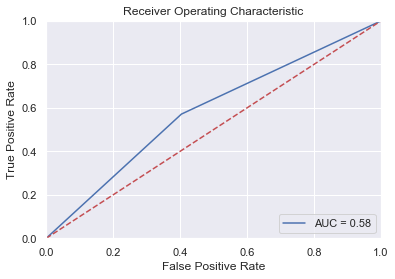

              precision    recall  f1-score   support

           0       0.92      0.60      0.72     26107
           1       0.15      0.57      0.24      3309

    accuracy                           0.59     29416
   macro avg       0.53      0.58      0.48     29416
weighted avg       0.83      0.59      0.67     29416



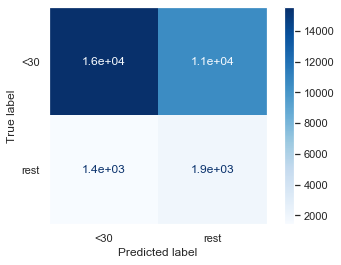

In [49]:
fpr, tpr, threshold = sk.metrics.roc_curve(bin_sub_y_test, best_preds_log)
roc_auc = sk.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(sk.metrics.classification_report(bin_sub_y_test, best_preds_log))

sk.metrics.plot_confusion_matrix(best_clf_log, bin_sub_X_test, bin_sub_y_test, display_labels=["<30", "rest"], cmap=plt.cm.Blues)
plt.grid(None)

Overall, the recall and precision for the <30 days readmission didn't change much when tuning the parameters.  We still get a precision of 0.15 and a recall at 0.57. We also have a consistent AUC at 0.58.

In [50]:
# Randomized Grid Search with Cross Validation
# tuning hyperparameters of Random Forest models
# takes ~5 minutes to run
pipe = Pipeline([('classifier', RandomForestClassifier(class_weight='balanced'))])
param_grid = [
    {'classifier' : [RandomForestClassifier(class_weight='balanced')],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]
clf_ml = sk.model_selection.RandomizedSearchCV(pipe, param_grid, n_iter = 5, scoring = 'roc_auc', cv = 5, verbose=3, n_jobs=2, random_state = 1001)
best_clf_ml = clf_ml.fit(bin_sub_X_train_smt, bin_sub_y_train_smt)
best_preds_ml = best_clf_ml.predict(bin_sub_X_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  4.0min finished


Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features=31, max_leaf_nodes=None,
                                        max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=80, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)
              precision    recall  f1-score   support

           0       0.

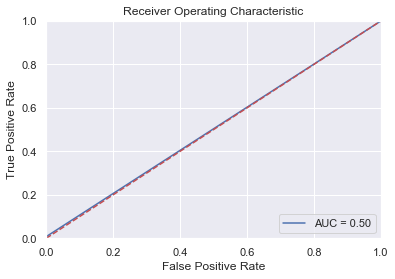

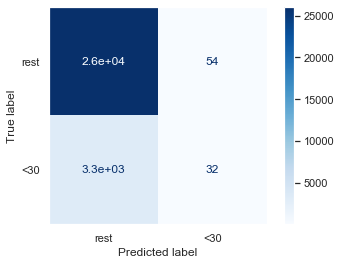

In [51]:
print(best_clf_ml.best_estimator_)
print(sk.metrics.classification_report(bin_sub_y_test, best_preds_ml))

fpr, tpr, threshold = sk.metrics.roc_curve(bin_sub_y_test, best_preds_ml)
roc_auc = sk.metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

sk.metrics.plot_confusion_matrix(best_clf_ml, bin_sub_X_test, bin_sub_y_test, display_labels=["rest","<30"], cmap=plt.cm.Blues)
plt.grid(None)

Overall, the recall and precision for the <30 days readmission decreased with the random forest model.  Although we used the resampled data, the model is still very biased towards predicting the patients who do not readmit within 30 days. 

Note: I ran a GridSearch using XGBoost as well, but the search took approximately 30 minutes to run and the best model gave extremely suboptimal results.  So I did not include it in this report. 

If we compare the results of these two models, we can see that the logistics regression gives us a better AUC and much better precision and recall for readmission within 30 days.  

<br>
That being said, even the logistic model is not particularly great. I would like to see the
AUC increase to at least 0.8. If this was something that I was presenting to
a business partner, I would continue with further analysis. This would include gathering more data, 
investigating other models, and looking at more variable selection methods. However, given these two models, I would select the logistic regression (with a binary response and the subset data) as the preferred option.  

Lets take a look at what features are the most important in this model.

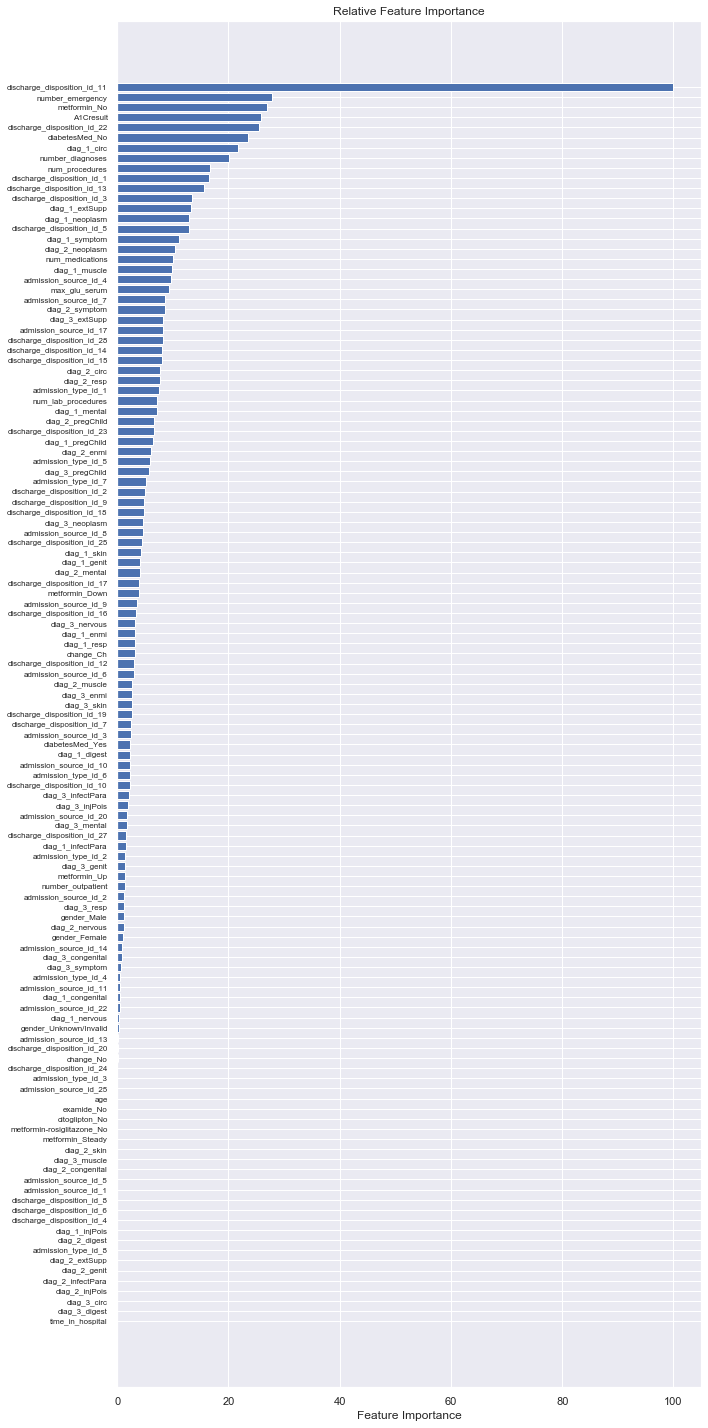

In [52]:
#calculating the relative importance of each feature
feature_importance_best_log = abs(best_clf_log.best_estimator_.named_steps['classifier'].coef_[0])
feature_importance_best_log = 100.0 * (feature_importance_best_log / feature_importance_best_log.max())

sorted_idx = np.argsort(feature_importance_best_log)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,20))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance_best_log[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(data_sub.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Feature Importance')
featax.set_title('Relative Feature Importance')

plt.tight_layout()   
plt.show()

Looking at the relative feature importance, the feature that has the strongest relative importance in predicting if someone readmits within 30 days is discharge disposition id 11 (patient expired), followed by number of emergency room visits, if they are not taking Metformin, and the A1c Result.  We can see the relative strength of each of the features in the graph.  


With additional time, I would like to investigate the symptomatic and medical data further, particularly the data related to diabetes.  I did include some additional analysis on the diag_1, diag_2, and diag_3 variables in the appendix.

## Part 3: Data Analysis and Exploration
##### The business owner you are partnering with asks for an update on the project.  What do you tell her?

The project is going well and I am pleased with our progress so far!  

We have developed a model that identifies patients who will readmit within 30 days 57% of the time. Unfortunately, we currently predict false positives 85% of the time, meaning that only 15% of the total number of patients that we predict will readmit actually do.  

We are continuing to gather more data that is more indicative of short term readmission in addition to building other models to improve on the accuracy.

Our model currently shows that the most important variables are: <br>

|Rank|Variable Name|Variable Description|
|-|-|-|
|1.|discharge_disposition_id_11|Patient expired|
|2.|number_emergency|Number of visits to emergency during the last year|
|3.|metformin_No|Not perscribed metformin|
|4.|A1Cresult|Range of result for test: None, Normal, >200, >300|
|5.|discharge_disposition_id_22|Discharged to another rehab facility|
|6.|diabetesMed_No|Primary diagnosis from circulatory group|
|7.|diag_1_circ|Patient is not taking diabetes medication|
|8.|number_diagnoses|Number of diagnoses entered into system|
|9.|num_procedures|Number of procedures (other than lab tests) performed during visit|
|10.|discharge_disposition_id_1|Discharged to home|


The highest factors in readmittance are whether or not the patient passed away, a number of metrics related to diabetes, and metrics related to their current and past visits to medical centers.  

Intuitively, we can confirm that if a patient passes away, they are unable to readmit within 30 days.  We can see two other discharges within the top ten features, discharging to hospice and discharging to another rehab facility.  <br>

Factors related to diabetes are quite relevant in short term readmission rates (includes A1Cresult, diabetesMed, and metformin).  A patient with a higher A1C result will be more likely to readmit, while someone who is already on diabetes medication is less likely.  <br>

Additionally, the patients medical records are also important, including the number of diagnoses and procedures during the visit.  The more a patient visits the emergency room, the less likely they will readmit.  In addition, the more diagnoses during the visit the less likely the patient will readmit.  On the flip side, the more procedures conducted during the visits, the more likely the patient will readmit.  

There are a number of factors that are associated with readmission and I would like to gather more data on the health of the patient in order to predict this status more accurately.  For example, next I will look closer at the patient's symptomatic and medication data. In addition, I want to follow up on you and determine what proportion of the patients who are readmitting are doing so for a scheduled follow up rather than an unforeseen event. In addition the model could be further optimized by accounting for the cost of an extended patient evaluation (if they are identifed by the model) versus the overall cost of short term readmittance. 

Overall, I'm happy with the results that we have so far, but I will be continue to look at ways to improve!


## Appendix

I wanted to take a look at how the grouping of diag_1, diag_2, and diag_3 affected the model.  Perhaps by grouping the data, I was loosing some predictive power for certain diagnoses.  

In [58]:
df_test = df.copy()
df_test = df_test.dropna(axis=0)
df_test.drop(['weight', 'payer_code', 'medical_specialty','encounter_id', 'patient_nbr', 'birth_date', 'admit_date'], axis=1, inplace=True)
df_test.head()

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age
27068,Caucasian,Female,3,3,1,10,65,1,28,1,...,Steady,No,No,No,No,No,Ch,Yes,<30,88
27128,Caucasian,Male,1,11,5,6,73,0,16,0,...,Steady,No,No,No,No,No,No,Yes,NO,101
27147,Caucasian,Male,1,1,7,2,58,3,12,0,...,No,No,No,No,No,No,No,Yes,>30,78
27186,Caucasian,Male,1,3,7,3,33,0,7,4,...,No,No,No,No,No,No,No,Yes,>30,48
27236,Caucasian,Male,3,1,1,2,5,4,11,0,...,No,No,No,No,No,No,No,Yes,>30,65


In [59]:
diag1_twt = pd.crosstab(index=df_test["diag_1"], 
                          columns=df_test["readmitted"])
diag1_twt['perc<30'] = diag1_twt['<30']/(diag1_twt['<30']+diag1_twt['>30']+diag1_twt['NO'])*100
diag1_twt['perc<30_total'] = (diag1_twt['<30']/diag1_twt['<30'].sum())*100
diag1_twt.sort_values(by=['perc<30_total'], ascending=False).head(50)

readmitted,<30,>30,NO,perc<30,perc<30_total
diag_1,,,,,
715,16,29,39,19.047619,16.0
414,9,46,42,9.278351,9.0
V58,9,4,1,64.285714,9.0
996,7,12,14,21.212121,7.0
428,6,35,27,8.823529,6.0
427,4,32,27,6.349206,4.0
786,3,27,17,6.382979,3.0
410,3,18,20,7.317073,3.0
584,2,5,8,13.333333,2.0


We can see that some of the diag_1 codes correspond to higher rates of readmission within 30 days.  

In [55]:
# data_subids = pd.get_dummies(df_model_subids)
# data_subids.head()

In [56]:
# #standardize the subset data
# sc_subids = sk.preprocessing.StandardScaler().fit(data_subids)
# data_subids_sc = sc_subids.transform(data_subids)
# binary encoder: subset of variables
# bin_subids_X_train, bin_subids_X_test, bin_subids_y_train, bin_subids_y_test = sk.model_selection.train_test_split(data_subids_sc, y_oh, test_size=0.3, random_state=0)
# #resampling
# smt = SMOTE()
# bin_subids_X_train_smt, bin_subinds_y_train_smt = smt.fit_sample(bin_subids_X_train, bin_subids_y_train)

In [57]:
# #modelling: logistic regression with binary encoding with ungrouped diag variables
# bin_log_subids_logm = sk.linear_model.LogisticRegressionCV(cv = 2, random_state=0, max_iter = 1000)
# bin_log_subids_model = bin_log_subids_logm.fit(bin_subids_X_train_smt, bin_subinds_y_train_smt)
# bin_log_subids_predictions = bin_log_subids_logm.predict(bin_subids_X_test)
# print(sk.metrics.classification_report(bin_subids_y_test, bin_log_subids_predictions))

Above I modelled with these diagnosis codes separate rather than grouped together.  This model takes quite a long time to run, which is why it is commented out.  The grouping versus ungrouped diags doesn't change the model significantly, except for the number of iterations required for convergence.  Therefore, we will stick with the groupings during the initial model building phase.  